TASK 4 Multilayer Perception for Image Classification

In [1]:
# Data Loader
import os
import numpy as np
from random import shuffle
from skimage.io import imread
from skimage.transform import resize

In [2]:
def gen_labels(im_name, pat1, pat2):
    '''
    Parameters
    ----------
    im_name : Str
        The image file name.
    pat1 : Str
        A string pattern in the filename for 1st class, e.g "Mel"
    pat2 : Str
        A string pattern in the filename 2nd class, e.g, "Nev"
    Returns
    -------
    Label : Numpy array        
        Class label of the filename name based on its pattern.
    '''
    if pat1 in im_name:
        label = np.array([0])
    elif pat2 in im_name:
        label = np.array([1])
    return label


def get_data(data_path, data_list, img_h, img_w):
    """
    Parameters
    ----------
    train_data_path : Str
        Path to the data directory
    train_list : List
        A list containing the name of the images.
    img_h : Int
        image height to be resized to.
    img_w : Int
        image width to be resized to.    
    Returns
    -------
    img_labels : Nested List
        A nested list containing the loaded images along with their
        correcponding labels.
    """
    img_labels = []      
    for item in enumerate(data_list):
        img = imread(os.path.join(data_path, item[1]), as_gray = True) # "as_grey"
        img = resize(img, (img_h, img_w), anti_aliasing = True).astype('float32')
        img_labels.append([np.array(img), gen_labels(item[1], 'Mel', 'Nev')])
       
        if item[0] % 100 == 0:
             print('Reading: {0}/{1}  of train images'.format(item[0], len(data_list)))
             
    shuffle(img_labels)
    return img_labels


def get_data_arrays(nested_list, img_h, img_w):
    """
    Parameters
    ----------
    nested_list : nested list
        nested list of image arrays with corresponding class labels.
    img_h : Int
        Image height.
    img_w : Int
        Image width.
    Returns
    -------
    img_arrays : Numpy array
        4D Array with the size of (n_data,img_h,img_w, 1)
    label_arrays : Numpy array
        1D array with the size (n_data).
    """
    img_arrays = np.zeros((len(nested_list), img_h, img_w), dtype = np.float32)
    label_arrays = np.zeros((len(nested_list)), dtype = np.int32)
    for ind in range(len(nested_list)):
        img_arrays[ind] = nested_list[ind][0]
        label_arrays[ind] = nested_list[ind][1]
    img_arrays = np.expand_dims(img_arrays, axis =3)
    return img_arrays, label_arrays


def get_train_test_arrays(train_data_path, test_data_path, train_list,
                          test_list, img_h, img_w):
    """
    Get the directory to the train and test sets, the files names and
    the size of the image and return the image and label arrays for
    train and test sets.
    """
   
    train_data = get_data(train_data_path, train_list, img_h, img_w)
    test_data = get_data(test_data_path, test_list, img_h, img_w)
   
    train_img, train_label =  get_data_arrays(train_data, img_h, img_w)
    test_img, test_label = get_data_arrays(test_data, img_h, img_w)
    del(train_data)
    del(test_data)      
    return train_img, test_img, train_label, test_label

In [3]:
img_w, img_h = 128, 128 # Setting the width and heights of the images.
data_path = '/DL_course_data/Lab1/Skin/' # Path to data root with two subdirs.
train_data_path = os.path.join(data_path, 'train')
test_data_path = os.path.join(data_path, 'test')
train_list = os.listdir(train_data_path)
test_list = os.listdir(test_data_path)
x_train, x_test, y_train, y_test = get_train_test_arrays(
     train_data_path, test_data_path,
     train_list, test_list, img_h, img_w)

Reading: 0/1000  of train images
Reading: 100/1000  of train images
Reading: 200/1000  of train images
Reading: 300/1000  of train images
Reading: 400/1000  of train images
Reading: 500/1000  of train images
Reading: 600/1000  of train images
Reading: 700/1000  of train images
Reading: 800/1000  of train images
Reading: 900/1000  of train images
Reading: 0/200  of train images
Reading: 100/200  of train images


In [4]:
print(type(x_train), x_train.shape,x_test.shape,img_w)

<class 'numpy.ndarray'> (1000, 128, 128, 1) (200, 128, 128, 1) 128


Functional API

In [5]:
from tensorflow.keras.layers import Input, Dense, Flatten 
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD

def model(img_width, img_height, img_ch, base_dense):
        """
        Functional API model.
        name the last layer as "out"; e.g., out = ....
        """        
        input_size = (img_width, img_height, img_ch)
        inputs_layer = Input(shape=input_size, name='input_layer')
        inputs_layer1 = Flatten()(inputs_layer)
        # TODO
        den1 = Dense(base_dense,activation = 'relu')(inputs_layer1)
        den2 = Dense(base_dense/2,activation = 'relu')(den1)
        den3 = Dense(base_dense/2,activation = 'relu')(den2)
        out = Dense(1, activation = 'sigmoid')(den3)
        clf = Model(inputs=inputs_layer, outputs=out)
        clf.summary()
        return clf



# n_epochs = 50 Batch_size = 16 base_dense = 64 LR = 0.0001

In [6]:
base_dense = 64
batchsize = 16
n_epochs = 50  
LR = 0.0001  #0.1
clf =  model(img_w, img_h, 1, base_dense)

clf.compile(loss='binary_crossentropy',
              optimizer = SGD(lr = LR),
              metrics=['binary_accuracy'])

clf_hist = clf.fit(x_train, y_train, epochs = n_epochs, batch_size = batchsize, validation_data = (x_test,y_test))

import matplotlib.pyplot as plt
plt.figure(figsize=(4, 4))
plt.title("Learning curve")
plt.plot(clf_hist.history["loss"], label="loss")
plt.plot(clf_hist.history["val_loss"], label="val_loss")
plt.plot( np.argmin(clf_hist.history["val_loss"]),
     np.min(clf_hist.history["val_loss"]),
     marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.legend();
plt.show()
print('the minimum var_loss is', np.min(clf_hist.history["val_loss"]))
print('the Best epoch nr is', np.argmin(clf_hist.history["val_loss"]))

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 128, 128, 1)]     0         
_________________________________________________________________
flatten (Flatten)            (None, 16384)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                1048640   
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,051,809
Trainable params: 1,051,809
Non-trainable params: 0
___________________________________________________

Epoch 44/50
1000/1000 [==============================] - 0s 333us/sample - loss: 0.6562 - binary_accuracy: 0.6550 - val_loss: 0.6579 - val_binary_accuracy: 0.6400
Epoch 45/50
1000/1000 [==============================] - 0s 320us/sample - loss: 0.6547 - binary_accuracy: 0.6680 - val_loss: 0.6568 - val_binary_accuracy: 0.6750
Epoch 46/50
1000/1000 [==============================] - 0s 316us/sample - loss: 0.6550 - binary_accuracy: 0.6520 - val_loss: 0.6561 - val_binary_accuracy: 0.6750
Epoch 47/50
1000/1000 [==============================] - 0s 315us/sample - loss: 0.6533 - binary_accuracy: 0.6610 - val_loss: 0.6614 - val_binary_accuracy: 0.5650
Epoch 48/50
1000/1000 [==============================] - 0s 313us/sample - loss: 0.6535 - binary_accuracy: 0.6470 - val_loss: 0.6552 - val_binary_accuracy: 0.6900
Epoch 49/50
1000/1000 [==============================] - 0s 327us/sample - loss: 0.6528 - binary_accuracy: 0.6570 - val_loss: 0.6567 - val_binary_accuracy: 0.6300
Epoch 50/50
1000/1000 

<Figure size 400x400 with 1 Axes>

the minimum var_loss is 0.6542976784706116
the Best epoch nr is 49


# n_epochs = 50 Batch_size = 16 base_dense = 64 LR = 0.1

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 128, 128, 1)]     0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                1048640   
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_6 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 1,051,809
Trainable params: 1,051,809
Non-trainable params: 0
_________________________________________________

Epoch 44/50
1000/1000 [==============================] - 0s 312us/sample - loss: 0.6942 - binary_accuracy: 0.4780 - val_loss: 0.6931 - val_binary_accuracy: 0.5000
Epoch 45/50
1000/1000 [==============================] - 0s 323us/sample - loss: 0.6936 - binary_accuracy: 0.4940 - val_loss: 0.6933 - val_binary_accuracy: 0.5000
Epoch 46/50
1000/1000 [==============================] - 0s 323us/sample - loss: 0.6941 - binary_accuracy: 0.4780 - val_loss: 0.6932 - val_binary_accuracy: 0.5000
Epoch 47/50
1000/1000 [==============================] - 0s 318us/sample - loss: 0.6936 - binary_accuracy: 0.5000 - val_loss: 0.6933 - val_binary_accuracy: 0.5000
Epoch 48/50
1000/1000 [==============================] - 0s 316us/sample - loss: 0.6937 - binary_accuracy: 0.5040 - val_loss: 0.6935 - val_binary_accuracy: 0.5000
Epoch 49/50
1000/1000 [==============================] - 0s 329us/sample - loss: 0.6939 - binary_accuracy: 0.5020 - val_loss: 0.6932 - val_binary_accuracy: 0.5000
Epoch 50/50
1000/1000 

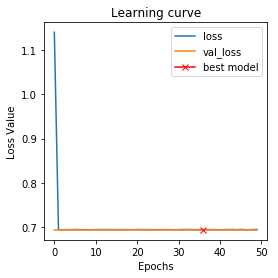

the minimum var_loss is 0.6931285214424133
the Best epoch nr is 36


In [7]:
base_dense = 64
batchsize = 16
n_epochs = 50  
LR = 0.1  #0.1
clf =  model(img_w, img_h, 1, base_dense)

clf.compile(loss='binary_crossentropy',
              optimizer = SGD(lr = LR),
              metrics=['binary_accuracy'])

clf_hist = clf.fit(x_train, y_train, epochs = n_epochs, batch_size = batchsize, validation_data = (x_test,y_test))

import matplotlib.pyplot as plt
plt.figure(figsize=(4, 4))
plt.title("Learning curve")
plt.plot(clf_hist.history["loss"], label="loss")
plt.plot(clf_hist.history["val_loss"], label="val_loss")
plt.plot( np.argmin(clf_hist.history["val_loss"]),
     np.min(clf_hist.history["val_loss"]),
     marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.legend();
plt.show()
print('the minimum var_loss is', np.min(clf_hist.history["val_loss"]))
print('the Best epoch nr is', np.argmin(clf_hist.history["val_loss"]))


# n_epochs = 150 Batch_size = 16 base_dense = 64 LR = 0.0001

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 128, 128, 1)]     0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                1048640   
_________________________________________________________________
dense_9 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_10 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
Total params: 1,051,809
Trainable params: 1,051,809
Non-trainable params: 0
_________________________________________________

Epoch 44/150
1000/1000 [==============================] - 0s 311us/sample - loss: 0.6771 - binary_accuracy: 0.6630 - val_loss: 0.6770 - val_binary_accuracy: 0.6800
Epoch 45/150
1000/1000 [==============================] - 0s 310us/sample - loss: 0.6768 - binary_accuracy: 0.6780 - val_loss: 0.6766 - val_binary_accuracy: 0.6750
Epoch 46/150
1000/1000 [==============================] - 0s 340us/sample - loss: 0.6766 - binary_accuracy: 0.6640 - val_loss: 0.6764 - val_binary_accuracy: 0.6650
Epoch 47/150
1000/1000 [==============================] - 0s 300us/sample - loss: 0.6762 - binary_accuracy: 0.6660 - val_loss: 0.6762 - val_binary_accuracy: 0.6800
Epoch 48/150
1000/1000 [==============================] - 0s 313us/sample - loss: 0.6760 - binary_accuracy: 0.6760 - val_loss: 0.6756 - val_binary_accuracy: 0.6750
Epoch 49/150
1000/1000 [==============================] - 0s 319us/sample - loss: 0.6760 - binary_accuracy: 0.6730 - val_loss: 0.6756 - val_binary_accuracy: 0.6650
Epoch 50/150
100

Epoch 94/150
1000/1000 [==============================] - 0s 286us/sample - loss: 0.6623 - binary_accuracy: 0.6890 - val_loss: 0.6639 - val_binary_accuracy: 0.7000
Epoch 95/150
1000/1000 [==============================] - 0s 291us/sample - loss: 0.6619 - binary_accuracy: 0.6870 - val_loss: 0.6641 - val_binary_accuracy: 0.6750
Epoch 96/150
1000/1000 [==============================] - 0s 283us/sample - loss: 0.6620 - binary_accuracy: 0.6990 - val_loss: 0.6635 - val_binary_accuracy: 0.7000
Epoch 97/150
1000/1000 [==============================] - 0s 285us/sample - loss: 0.6612 - binary_accuracy: 0.6800 - val_loss: 0.6634 - val_binary_accuracy: 0.6850
Epoch 98/150
1000/1000 [==============================] - 0s 288us/sample - loss: 0.6607 - binary_accuracy: 0.6910 - val_loss: 0.6640 - val_binary_accuracy: 0.6750
Epoch 99/150
1000/1000 [==============================] - 0s 297us/sample - loss: 0.6606 - binary_accuracy: 0.6920 - val_loss: 0.6630 - val_binary_accuracy: 0.6900
Epoch 100/150
10

Epoch 144/150
1000/1000 [==============================] - 0s 303us/sample - loss: 0.6475 - binary_accuracy: 0.6930 - val_loss: 0.6512 - val_binary_accuracy: 0.7100
Epoch 145/150
1000/1000 [==============================] - 0s 325us/sample - loss: 0.6462 - binary_accuracy: 0.7000 - val_loss: 0.6514 - val_binary_accuracy: 0.6650
Epoch 146/150
1000/1000 [==============================] - 0s 306us/sample - loss: 0.6463 - binary_accuracy: 0.6870 - val_loss: 0.6509 - val_binary_accuracy: 0.6950
Epoch 147/150
1000/1000 [==============================] - 0s 298us/sample - loss: 0.6465 - binary_accuracy: 0.7010 - val_loss: 0.6505 - val_binary_accuracy: 0.6900
Epoch 148/150
1000/1000 [==============================] - 0s 302us/sample - loss: 0.6454 - binary_accuracy: 0.6940 - val_loss: 0.6512 - val_binary_accuracy: 0.6750
Epoch 149/150
1000/1000 [==============================] - 0s 308us/sample - loss: 0.6460 - binary_accuracy: 0.6940 - val_loss: 0.6500 - val_binary_accuracy: 0.6950
Epoch 150/

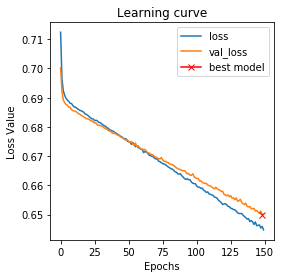

the minimum var_loss is 0.6500049352645874
the Best epoch nr is 148


In [8]:
base_dense = 64
batchsize = 16
n_epochs = 150  
LR = 0.0001  #0.1
clf =  model(img_w, img_h, 1, base_dense)

clf.compile(loss='binary_crossentropy',
              optimizer = SGD(lr = LR),
              metrics=['binary_accuracy'])

clf_hist = clf.fit(x_train, y_train, epochs = n_epochs, batch_size = batchsize, validation_data = (x_test,y_test))

import matplotlib.pyplot as plt
plt.figure(figsize=(4, 4))
plt.title("Learning curve")
plt.plot(clf_hist.history["loss"], label="loss")
plt.plot(clf_hist.history["val_loss"], label="val_loss")
plt.plot( np.argmin(clf_hist.history["val_loss"]),
     np.min(clf_hist.history["val_loss"]),
     marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.legend();
plt.show()
print('the minimum var_loss is', np.min(clf_hist.history["val_loss"]))
print('the Best epoch nr is', np.argmin(clf_hist.history["val_loss"]))


# n_epochs = 150 Batch_size = 16 base_dense = 256 LR = 0.0001

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 128, 128, 1)]     0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               4194560   
_________________________________________________________________
dense_13 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_14 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 129       
Total params: 4,244,097
Trainable params: 4,244,097
Non-trainable params: 0
_________________________________________________

Epoch 44/150
1000/1000 [==============================] - 0s 338us/sample - loss: 0.6525 - binary_accuracy: 0.6930 - val_loss: 0.6583 - val_binary_accuracy: 0.7050
Epoch 45/150
1000/1000 [==============================] - 0s 321us/sample - loss: 0.6523 - binary_accuracy: 0.6870 - val_loss: 0.6578 - val_binary_accuracy: 0.7100
Epoch 46/150
1000/1000 [==============================] - 0s 321us/sample - loss: 0.6514 - binary_accuracy: 0.6930 - val_loss: 0.6575 - val_binary_accuracy: 0.6950
Epoch 47/150
1000/1000 [==============================] - 0s 336us/sample - loss: 0.6511 - binary_accuracy: 0.6910 - val_loss: 0.6579 - val_binary_accuracy: 0.6800
Epoch 48/150
1000/1000 [==============================] - 0s 309us/sample - loss: 0.6495 - binary_accuracy: 0.6790 - val_loss: 0.6576 - val_binary_accuracy: 0.6750
Epoch 49/150
1000/1000 [==============================] - 0s 310us/sample - loss: 0.6493 - binary_accuracy: 0.7000 - val_loss: 0.6563 - val_binary_accuracy: 0.6950
Epoch 50/150
100

Epoch 94/150
1000/1000 [==============================] - 0s 346us/sample - loss: 0.6298 - binary_accuracy: 0.7010 - val_loss: 0.6403 - val_binary_accuracy: 0.6900
Epoch 95/150
1000/1000 [==============================] - 0s 328us/sample - loss: 0.6278 - binary_accuracy: 0.6930 - val_loss: 0.6402 - val_binary_accuracy: 0.7000
Epoch 96/150
1000/1000 [==============================] - 0s 312us/sample - loss: 0.6284 - binary_accuracy: 0.6970 - val_loss: 0.6395 - val_binary_accuracy: 0.7200
Epoch 97/150
1000/1000 [==============================] - 0s 321us/sample - loss: 0.6279 - binary_accuracy: 0.7020 - val_loss: 0.6424 - val_binary_accuracy: 0.6550
Epoch 98/150
1000/1000 [==============================] - 0s 337us/sample - loss: 0.6281 - binary_accuracy: 0.6980 - val_loss: 0.6386 - val_binary_accuracy: 0.7300
Epoch 99/150
1000/1000 [==============================] - 0s 316us/sample - loss: 0.6273 - binary_accuracy: 0.6960 - val_loss: 0.6405 - val_binary_accuracy: 0.6650
Epoch 100/150
10

Epoch 144/150
1000/1000 [==============================] - 0s 309us/sample - loss: 0.6120 - binary_accuracy: 0.7080 - val_loss: 0.6293 - val_binary_accuracy: 0.6750
Epoch 145/150
1000/1000 [==============================] - 0s 315us/sample - loss: 0.6124 - binary_accuracy: 0.7110 - val_loss: 0.6318 - val_binary_accuracy: 0.6650
Epoch 146/150
1000/1000 [==============================] - 0s 336us/sample - loss: 0.6118 - binary_accuracy: 0.7060 - val_loss: 0.6320 - val_binary_accuracy: 0.6600
Epoch 147/150
1000/1000 [==============================] - 0s 318us/sample - loss: 0.6123 - binary_accuracy: 0.7020 - val_loss: 0.6289 - val_binary_accuracy: 0.6750
Epoch 148/150
1000/1000 [==============================] - 0s 317us/sample - loss: 0.6117 - binary_accuracy: 0.7020 - val_loss: 0.6276 - val_binary_accuracy: 0.7300
Epoch 149/150
1000/1000 [==============================] - 0s 313us/sample - loss: 0.6118 - binary_accuracy: 0.7180 - val_loss: 0.6273 - val_binary_accuracy: 0.7300
Epoch 150/

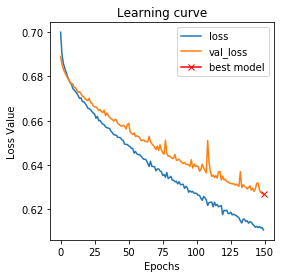

the minimum var_loss is 0.6269499969482422
the Best epoch nr is 149


In [9]:
base_dense = 256
batchsize = 16
n_epochs = 150  
LR = 0.0001  #0.1
clf =  model(img_w, img_h, 1, base_dense)

clf.compile(loss='binary_crossentropy',
              optimizer = SGD(lr = LR),
              metrics=['binary_accuracy'])

clf_hist = clf.fit(x_train, y_train, epochs = n_epochs, batch_size = batchsize, validation_data = (x_test,y_test))

import matplotlib.pyplot as plt
plt.figure(figsize=(4, 4))
plt.title("Learning curve")
plt.plot(clf_hist.history["loss"], label="loss")
plt.plot(clf_hist.history["val_loss"], label="val_loss")
plt.plot( np.argmin(clf_hist.history["val_loss"]),
     np.min(clf_hist.history["val_loss"]),
     marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.legend();
plt.show()
print('the minimum var_loss is', np.min(clf_hist.history["val_loss"]))
print('the Best epoch nr is', np.argmin(clf_hist.history["val_loss"]))


# TASK 5 Convolutional Neural Network

Sequential API

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D

In [11]:
def model(img_width, img_height, img_ch, base):
        """
        Functional API model.
        name the last layer as "out"; e.g., out = ....
        """        
        input_size = (img_width, img_height, img_ch)
        inputs_layer = Input(shape=input_size, name='input_layer')
        inputs_layer1 = inputs_layer
#         inputs_layer1 = Flatten()(inputs_layer)  For CNN no need to Flatten?
        conv1 = Conv2D(base, kernel_size = (3, 3), activation='relu',
                      strides=1, padding='same',
                      input_shape = (img_width, img_height, img_ch))(inputs_layer1)
        pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
        conv2 = Conv2D(base*2, kernel_size = (3, 3), activation='relu',
               strides=1, padding='same')(pool1)
        pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
#         Dense layer only can handle 1D data?
        inputs_dense = Flatten()(pool2)
        hidden4 = Dense(base*2, activation='relu')(inputs_dense)
        out = Dense(1, activation='sigmoid')(hidden4)
        clf = Model(inputs=inputs_layer, outputs=out)
        clf.summary()
        return clf

In [12]:
# def model(img_ch, img_width, img_height):
#      model = Sequential()
#      model.add(Conv2D(base, kernel_size = (3, 3), activation='relu',
#                       strides=1, padding='same',
#                       input_shape = (img_width, img_height, img_ch)))
#      model.add(MaxPooling2D(pool_size=(2, 2)))
 
#      model.add(Conv2D(base*2, kernel_size = (3, 3), activation='relu',
#                strides=1, padding='same'))
#      model.add(MaxPooling2D(pool_size=(2, 2)))
     
#      model.add(Flatten())
#      model.add(Dense(base*2, activation='relu'))
#      model.add(Dense(1, activation='sigmoid'))
#      model.summary()
#      return model

# epochs=20 batch_size=8 number_layer=32 lr=0.00001

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 64)                4194

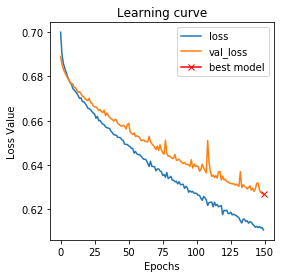

In [13]:
firstlayer = 32
batchsize = 8
n_epochs = 20   # 20
learningrate = 0.00001   #0.00001

clf =  model(img_w, img_h, 1,firstlayer)

clf.compile(loss='binary_crossentropy',
              optimizer = SGD(lr = learningrate),
              metrics=['binary_accuracy'])

clf_hist2 = clf.fit(x_train, y_train, epochs = n_epochs, batch_size = batchsize, validation_data = (x_test,y_test))

import matplotlib.pyplot as plt
plt.figure(figsize=(4, 4))
plt.title("Learning curve")
plt.plot(clf_hist.history["loss"], label="loss")
plt.plot(clf_hist.history["val_loss"], label="val_loss")
plt.plot( np.argmin(clf_hist.history["val_loss"]),
     np.min(clf_hist.history["val_loss"]),
     marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.legend();
plt.show()

# epochs=200 batch_size=8 number_layer=32 lr=0.00001

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 32)      320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_18 (Dense)             (None, 64)                4194

1000/1000 [==============================] - 1s 836us/sample - loss: 0.6923 - binary_accuracy: 0.5180 - val_loss: 0.6923 - val_binary_accuracy: 0.5050
Epoch 43/200
1000/1000 [==============================] - 1s 831us/sample - loss: 0.6923 - binary_accuracy: 0.5200 - val_loss: 0.6923 - val_binary_accuracy: 0.5100
Epoch 44/200
1000/1000 [==============================] - 1s 844us/sample - loss: 0.6923 - binary_accuracy: 0.5210 - val_loss: 0.6923 - val_binary_accuracy: 0.5050
Epoch 45/200
1000/1000 [==============================] - 1s 824us/sample - loss: 0.6923 - binary_accuracy: 0.5210 - val_loss: 0.6923 - val_binary_accuracy: 0.5050
Epoch 46/200
1000/1000 [==============================] - 1s 827us/sample - loss: 0.6923 - binary_accuracy: 0.5210 - val_loss: 0.6923 - val_binary_accuracy: 0.5200
Epoch 47/200
1000/1000 [==============================] - 1s 821us/sample - loss: 0.6923 - binary_accuracy: 0.5200 - val_loss: 0.6923 - val_binary_accuracy: 0.5300
Epoch 48/200
1000/1000 [=====

1000/1000 [==============================] - 1s 869us/sample - loss: 0.6918 - binary_accuracy: 0.5910 - val_loss: 0.6918 - val_binary_accuracy: 0.6200
Epoch 93/200
1000/1000 [==============================] - 1s 834us/sample - loss: 0.6918 - binary_accuracy: 0.5950 - val_loss: 0.6918 - val_binary_accuracy: 0.6250
Epoch 94/200
1000/1000 [==============================] - 1s 842us/sample - loss: 0.6918 - binary_accuracy: 0.5950 - val_loss: 0.6918 - val_binary_accuracy: 0.6300
Epoch 95/200
1000/1000 [==============================] - 1s 830us/sample - loss: 0.6918 - binary_accuracy: 0.5940 - val_loss: 0.6918 - val_binary_accuracy: 0.6300
Epoch 96/200
1000/1000 [==============================] - 1s 844us/sample - loss: 0.6918 - binary_accuracy: 0.5940 - val_loss: 0.6918 - val_binary_accuracy: 0.6350
Epoch 97/200
1000/1000 [==============================] - 1s 823us/sample - loss: 0.6918 - binary_accuracy: 0.5990 - val_loss: 0.6918 - val_binary_accuracy: 0.6350
Epoch 98/200
1000/1000 [=====

Epoch 142/200
1000/1000 [==============================] - 1s 845us/sample - loss: 0.6914 - binary_accuracy: 0.6100 - val_loss: 0.6914 - val_binary_accuracy: 0.6050
Epoch 143/200
1000/1000 [==============================] - 1s 834us/sample - loss: 0.6914 - binary_accuracy: 0.6120 - val_loss: 0.6914 - val_binary_accuracy: 0.6050
Epoch 144/200
1000/1000 [==============================] - 1s 860us/sample - loss: 0.6914 - binary_accuracy: 0.6130 - val_loss: 0.6914 - val_binary_accuracy: 0.6050
Epoch 145/200
1000/1000 [==============================] - 1s 836us/sample - loss: 0.6914 - binary_accuracy: 0.6140 - val_loss: 0.6914 - val_binary_accuracy: 0.6100
Epoch 146/200
1000/1000 [==============================] - 1s 842us/sample - loss: 0.6914 - binary_accuracy: 0.6120 - val_loss: 0.6914 - val_binary_accuracy: 0.6100
Epoch 147/200
1000/1000 [==============================] - 1s 818us/sample - loss: 0.6914 - binary_accuracy: 0.6130 - val_loss: 0.6914 - val_binary_accuracy: 0.6100
Epoch 148/

Epoch 192/200
1000/1000 [==============================] - 1s 836us/sample - loss: 0.6911 - binary_accuracy: 0.5980 - val_loss: 0.6910 - val_binary_accuracy: 0.5600
Epoch 193/200
1000/1000 [==============================] - 1s 852us/sample - loss: 0.6911 - binary_accuracy: 0.5980 - val_loss: 0.6910 - val_binary_accuracy: 0.5600
Epoch 194/200
1000/1000 [==============================] - 1s 856us/sample - loss: 0.6911 - binary_accuracy: 0.5940 - val_loss: 0.6910 - val_binary_accuracy: 0.5600
Epoch 195/200
1000/1000 [==============================] - 1s 857us/sample - loss: 0.6911 - binary_accuracy: 0.5910 - val_loss: 0.6910 - val_binary_accuracy: 0.5600
Epoch 196/200
1000/1000 [==============================] - 1s 830us/sample - loss: 0.6911 - binary_accuracy: 0.5930 - val_loss: 0.6910 - val_binary_accuracy: 0.5600
Epoch 197/200
1000/1000 [==============================] - 1s 847us/sample - loss: 0.6911 - binary_accuracy: 0.6090 - val_loss: 0.6910 - val_binary_accuracy: 0.5600
Epoch 198/

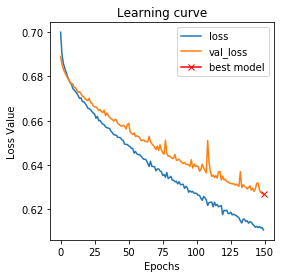

In [14]:
firstlayer = 32
batchsize = 8
n_epochs = 200   # 20
learningrate = 0.00001   #0.00001

clf =  model(img_w, img_h, 1,firstlayer)

clf.compile(loss='binary_crossentropy',
              optimizer = SGD(lr = learningrate),
              metrics=['binary_accuracy'])

clf_hist2 = clf.fit(x_train, y_train, epochs = n_epochs, batch_size = batchsize, validation_data = (x_test,y_test))

import matplotlib.pyplot as plt
plt.figure(figsize=(4, 4))
plt.title("Learning curve")
plt.plot(clf_hist.history["loss"], label="loss")
plt.plot(clf_hist.history["val_loss"], label="val_loss")
plt.plot( np.argmin(clf_hist.history["val_loss"]),
     np.min(clf_hist.history["val_loss"]),
     marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.legend();
plt.show()

# epochs=200 batch_size=8 number_layer=32 lr=0.0001

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 128, 128, 32)      320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_20 (Dense)             (None, 64)                4194

1000/1000 [==============================] - 1s 841us/sample - loss: 0.6908 - binary_accuracy: 0.6180 - val_loss: 0.6902 - val_binary_accuracy: 0.6350
Epoch 43/200
1000/1000 [==============================] - 1s 850us/sample - loss: 0.6907 - binary_accuracy: 0.5810 - val_loss: 0.6901 - val_binary_accuracy: 0.6550
Epoch 44/200
1000/1000 [==============================] - 1s 843us/sample - loss: 0.6907 - binary_accuracy: 0.6130 - val_loss: 0.6901 - val_binary_accuracy: 0.6500
Epoch 45/200
1000/1000 [==============================] - 1s 844us/sample - loss: 0.6906 - binary_accuracy: 0.6230 - val_loss: 0.6900 - val_binary_accuracy: 0.6400
Epoch 46/200
1000/1000 [==============================] - 1s 847us/sample - loss: 0.6905 - binary_accuracy: 0.5840 - val_loss: 0.6900 - val_binary_accuracy: 0.6700
Epoch 47/200
1000/1000 [==============================] - 1s 857us/sample - loss: 0.6905 - binary_accuracy: 0.6070 - val_loss: 0.6899 - val_binary_accuracy: 0.6700
Epoch 48/200
1000/1000 [=====

1000/1000 [==============================] - 1s 855us/sample - loss: 0.6875 - binary_accuracy: 0.6430 - val_loss: 0.6867 - val_binary_accuracy: 0.6900
Epoch 93/200
1000/1000 [==============================] - 1s 814us/sample - loss: 0.6874 - binary_accuracy: 0.6260 - val_loss: 0.6865 - val_binary_accuracy: 0.6900
Epoch 94/200
1000/1000 [==============================] - 1s 832us/sample - loss: 0.6872 - binary_accuracy: 0.6270 - val_loss: 0.6864 - val_binary_accuracy: 0.6950
Epoch 95/200
1000/1000 [==============================] - 1s 840us/sample - loss: 0.6871 - binary_accuracy: 0.6560 - val_loss: 0.6862 - val_binary_accuracy: 0.6900
Epoch 96/200
1000/1000 [==============================] - 1s 835us/sample - loss: 0.6870 - binary_accuracy: 0.6530 - val_loss: 0.6861 - val_binary_accuracy: 0.6900
Epoch 97/200
1000/1000 [==============================] - 1s 824us/sample - loss: 0.6869 - binary_accuracy: 0.6610 - val_loss: 0.6860 - val_binary_accuracy: 0.6850
Epoch 98/200
1000/1000 [=====

Epoch 142/200
1000/1000 [==============================] - 1s 821us/sample - loss: 0.6833 - binary_accuracy: 0.6640 - val_loss: 0.6821 - val_binary_accuracy: 0.6950
Epoch 143/200
1000/1000 [==============================] - 1s 842us/sample - loss: 0.6831 - binary_accuracy: 0.6700 - val_loss: 0.6820 - val_binary_accuracy: 0.6750
Epoch 144/200
1000/1000 [==============================] - 1s 833us/sample - loss: 0.6831 - binary_accuracy: 0.6340 - val_loss: 0.6819 - val_binary_accuracy: 0.6950
Epoch 145/200
1000/1000 [==============================] - 1s 855us/sample - loss: 0.6830 - binary_accuracy: 0.6400 - val_loss: 0.6818 - val_binary_accuracy: 0.7050
Epoch 146/200
1000/1000 [==============================] - 1s 827us/sample - loss: 0.6829 - binary_accuracy: 0.6560 - val_loss: 0.6817 - val_binary_accuracy: 0.6950
Epoch 147/200
1000/1000 [==============================] - 1s 843us/sample - loss: 0.6828 - binary_accuracy: 0.6350 - val_loss: 0.6816 - val_binary_accuracy: 0.6900
Epoch 148/

Epoch 192/200
1000/1000 [==============================] - 1s 861us/sample - loss: 0.6780 - binary_accuracy: 0.6470 - val_loss: 0.6765 - val_binary_accuracy: 0.7150
Epoch 193/200
1000/1000 [==============================] - 1s 837us/sample - loss: 0.6779 - binary_accuracy: 0.6660 - val_loss: 0.6764 - val_binary_accuracy: 0.7100
Epoch 194/200
1000/1000 [==============================] - 1s 852us/sample - loss: 0.6778 - binary_accuracy: 0.6780 - val_loss: 0.6763 - val_binary_accuracy: 0.7000
Epoch 195/200
1000/1000 [==============================] - 1s 823us/sample - loss: 0.6778 - binary_accuracy: 0.6560 - val_loss: 0.6761 - val_binary_accuracy: 0.7050
Epoch 196/200
1000/1000 [==============================] - 1s 857us/sample - loss: 0.6776 - binary_accuracy: 0.6690 - val_loss: 0.6760 - val_binary_accuracy: 0.7000
Epoch 197/200
1000/1000 [==============================] - 1s 841us/sample - loss: 0.6775 - binary_accuracy: 0.6660 - val_loss: 0.6759 - val_binary_accuracy: 0.7000
Epoch 198/

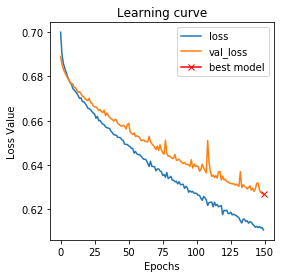

In [15]:
firstlayer = 32
batchsize = 8
n_epochs = 200   # 20
learningrate = 0.0001   #0.00001

clf =  model(img_w, img_h, 1,firstlayer)

clf.compile(loss='binary_crossentropy',
              optimizer = SGD(lr = learningrate),
              metrics=['binary_accuracy'])

clf_hist2 = clf.fit(x_train, y_train, epochs = n_epochs, batch_size = batchsize, validation_data = (x_test,y_test))

import matplotlib.pyplot as plt
plt.figure(figsize=(4, 4))
plt.title("Learning curve")
plt.plot(clf_hist.history["loss"], label="loss")
plt.plot(clf_hist.history["val_loss"], label="val_loss")
plt.plot( np.argmin(clf_hist.history["val_loss"]),
     np.min(clf_hist.history["val_loss"]),
     marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.legend();
plt.show()